In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379371 sha256=f7b0d7c7c6eab3cd12bc063fbba7141ee4a3e3ae2c1b3e459f312658225a6476
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [ ]:
# environment create
env = gym.make("Taxi-v3", render_mode=None)
print(f"Action Space: {env.action_space}")
print(f"State Space: {env.observation_space}")
print(f"Total States: {env.observation_space.n}")
print(f"Total Actions: {env.action_space.n}")

#actions
print("\nActions:")
print("0: Move south")
print("1: Move north")
print("2: Move east")
print("3: Move west")
print("4: Pickup passenger")
print("5: Drop off passenger")

# rewards
print("\nRewards:")
print("-1: Per time step")
print("-10: For illegal pickup/dropoff actions")
print("+20: For successful dropoff")

Action Space: Discrete(6)
State Space: Discrete(500)
Total States: 500
Total Actions: 6

Actions:
0: Move south
1: Move north
2: Move east
3: Move west
4: Pickup passenger
5: Drop off passenger

Rewards:
-1: Per time step
-10: For illegal pickup/dropoff actions
+20: For successful dropoff


In [ ]:
pip install numpy==1.23.5


In [ ]:
# initial state
state = env.reset()
action = env.action_space.sample()

# transition function
next_state, reward, terminated, done, info = env.step(action)

print("Current State:", state)
print("Action Taken:", action)
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)
print ("Terminated:", terminated)



Current State: (401, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})
Action Taken: 3
Next State: 401
Reward: -1
Done: False
Terminated: False


In [ ]:
# Q-learning parameters
alpha = 0.1  # learning rate
gamma = 0.99  # discount factor
epsilon = 1.0  # initial exploration rate
epsilon_decay = 0.995  # decay rate for epsilon
epsilon_min = 0.01  # minimum exploration rate
max_steps = 200  # maximum steps per episode

# Q-table
def initialize_q_table(state_size, action_size):

    return np.zeros([state_size, action_size])

# epsilon-greedy policy
def epsilon_greedy_policy(q_table, state, epsilon, action_size):

    if np.random.random() < epsilon:
        return np.random.randint(action_size)  # random action
    else:
        return np.argmax(q_table[state])  # best known action

# initialise Q-table
q_table = initialize_q_table(env.observation_space.n, env.action_space.n)

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

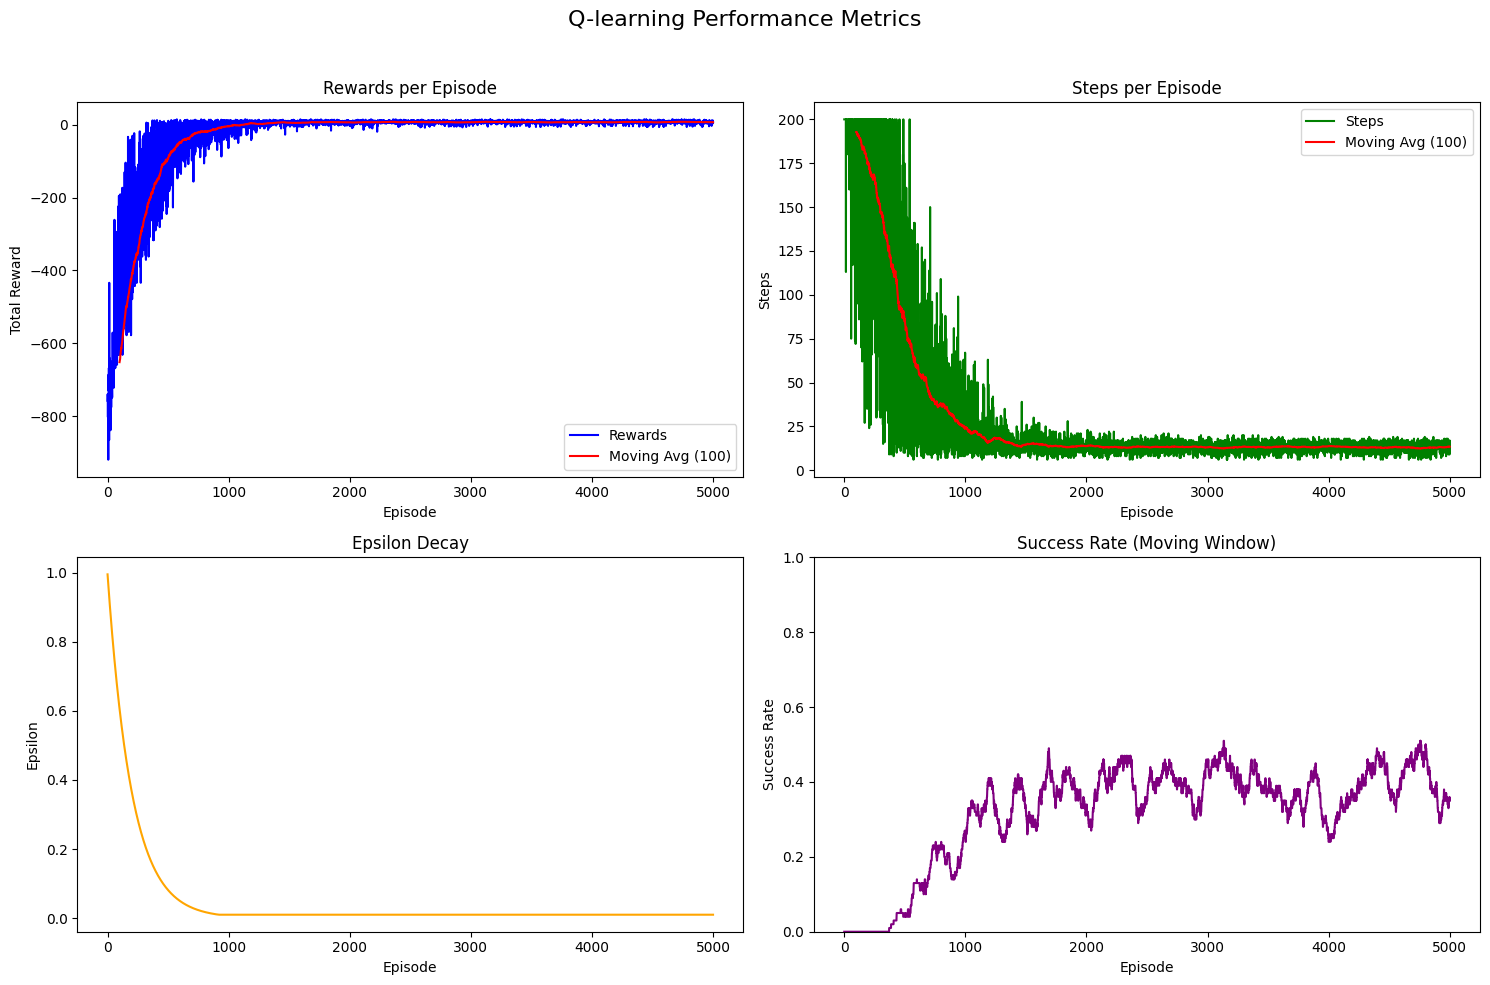

Evaluation Results:
Average Reward: 7.66
Average Steps: 13.34
Success Rate: 35.00%


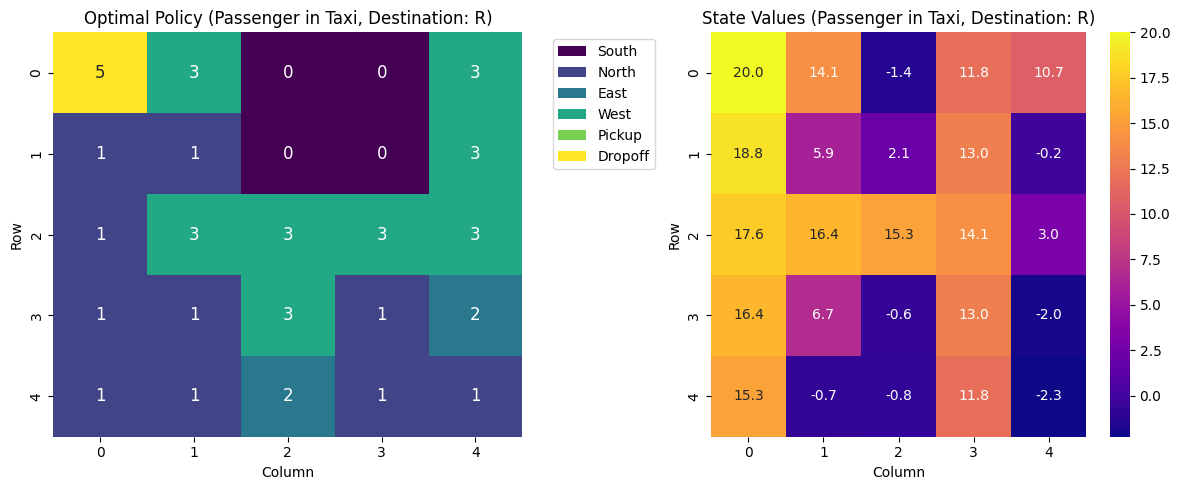

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Q-learning algorithm
def q_learning(env, episodes, max_steps, alpha, gamma, epsilon,
               epsilon_decay, epsilon_min, render=False):

    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    rewards_list = []
    steps_list = []
    epsilon_values = []
    success_rate = []
    successes_window = []
    window_size = 100

    for episode in tqdm(range(episodes), desc="Training Progress"):
        state, info = env.reset()
        total_reward = 0
        steps = 0
        done = False
        truncated = False

        while not done and not truncated and steps < max_steps:
            # select action using epsilon-greedy policy
            action = epsilon_greedy_policy(q_table, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, info = env.step(action)

            # update Q-value
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state, best_next_action]
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            state = next_state
            total_reward += reward
            steps += 1

        # epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        rewards_list.append(total_reward)
        steps_list.append(steps)
        epsilon_values.append(epsilon)

        # track success (reaching high reward)
        if total_reward >= 9:  # successful trip has a reward over 9
            successes_window.append(1)
        else:
            successes_window.append(0)

        if len(successes_window) > window_size:
            successes_window.pop(0)

        current_success_rate = sum(successes_window) / len(successes_window)
        success_rate.append(current_success_rate)

    return q_table, rewards_list, steps_list, epsilon_values, success_rate

# q-learning algorithm
num_episodes = 5000
q_table, rewards, steps, epsilons, success_rates = q_learning(
    env, num_episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min
)


def plot_training_results(rewards, steps, epsilons, success_rates):

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Q-learning Performance Metrics', fontsize=16)

#rewards plot
    axs[0, 0].plot(rewards, 'b')
    axs[0, 0].set_title('Rewards per Episode')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Total Reward')
#average of rewards
    window_size = 100
    rewards_smoothed = pd.Series(rewards).rolling(window=window_size).mean()
    axs[0, 0].plot(rewards_smoothed, 'r')
    axs[0, 0].legend(['Rewards', f'Moving Avg ({window_size})'])

#steps
    axs[0, 1].plot(steps, 'g')
    axs[0, 1].set_title('Steps per Episode')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Steps')

# moving average of steps
    steps_smoothed = pd.Series(steps).rolling(window=window_size).mean()
    axs[0, 1].plot(steps_smoothed, 'r')
    axs[0, 1].legend(['Steps', f'Moving Avg ({window_size})'])

#epsilon decay
    axs[1, 0].plot(epsilons, 'orange')
    axs[1, 0].set_title('Epsilon Decay')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Epsilon')

#success rate
    axs[1, 1].plot(success_rates, 'purple')
    axs[1, 1].set_title('Success Rate (Moving Window)')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Success Rate')
    axs[1, 1].set_ylim([0, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_training_results(rewards, steps, epsilons, success_rates)

#eval of trained agent
def evaluate_agent(env, q_table, num_episodes=100, max_steps=100, render=False):

    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for _ in range(num_episodes):
        state, info = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        truncated = False

        while not done and not truncated and steps < max_steps:
            # choice of best action
            action = np.argmax(q_table[state])
            next_state, reward, done, truncated, info = env.step(action)

            state = next_state
            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

        if episode_reward >= 9:
            successful_episodes += 1

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = successful_episodes / num_episodes

    return avg_reward, avg_steps, success_rate


avg_reward, avg_steps, success_rate = evaluate_agent(env, q_table)
print(f"Evaluation Results:")
print(f"Average Reward: {avg_reward:.2f}")
print(f"Average Steps: {avg_steps:.2f}")
print(f"Success Rate: {success_rate:.2%}")

# heatmap of optimal policy
def visualize_policy(q_table, env):

    passenger_loc = 4
    destination = 0

    policy_grid = np.zeros((5, 5), dtype=int)
    value_grid = np.zeros((5, 5))

    for row in range(5):
        for col in range(5):
            state_idx = env.unwrapped.encode(row, col, passenger_loc, destination)
            best_action = np.argmax(q_table[state_idx])
            policy_grid[row, col] = best_action
            value_grid[row, col] = np.max(q_table[state_idx])

    action_names = ['South', 'North', 'East', 'West', 'Pickup', 'Dropoff']


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(policy_grid, annot=True, cmap='viridis', cbar=False,
                fmt='d', annot_kws={"size": 12})
    plt.title(f'Optimal Policy (Passenger in Taxi, Destination: R)')
    plt.xlabel('Column')
    plt.ylabel('Row')

    #create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=plt.cm.viridis(i/5), label=action_names[i])
                      for i in range(6)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

 #value grid plot
    plt.subplot(1, 2, 2)
    sns.heatmap(value_grid, annot=True, cmap='plasma',
                fmt='.1f', annot_kws={"size": 10})
    plt.title(f'State Values (Passenger in Taxi, Destination: R)')
    plt.xlabel('Column')
    plt.ylabel('Row')

    plt.tight_layout()
    plt.show()

visualize_policy(q_table, env)


Running experiment: Baseline


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Baseline:
Average Reward: -39.74
Average Steps: 51.29
Success Rate: 37.00%

Running experiment: High Learning Rate


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for High Learning Rate:
Average Reward: 4.24
Average Steps: 15.92
Success Rate: 48.00%

Running experiment: Low Discount Factor


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Low Discount Factor:
Average Reward: -60.06
Average Steps: 67.62
Success Rate: 31.00%

Running experiment: Fast Exploration Decay


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Fast Exploration Decay:
Average Reward: -60.56
Average Steps: 60.89
Success Rate: 33.00%

Running experiment: Slow Exploration Decay


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Slow Exploration Decay:
Average Reward: -57.07
Average Steps: 65.26
Success Rate: 30.00%


,Experiment,Alpha,Gamma,Epsilon Decay,Avg Reward,Avg Steps,Success Rate
0,Baseline,0.1,0.99,0.995,-39.74,51.29,37.00%
1,High Learning Rate,0.5,0.99,0.995,4.24,15.92,48.00%
2,Low Discount Factor,0.1,0.80,0.995,-60.06,67.62,31.00%
3,Fast Exploration Decay,0.1,0.99,0.990,-60.56,60.89,33.00%
4,Slow Exploration Decay,0.1,0.99,0.999,-57.07,65.26,30.00%


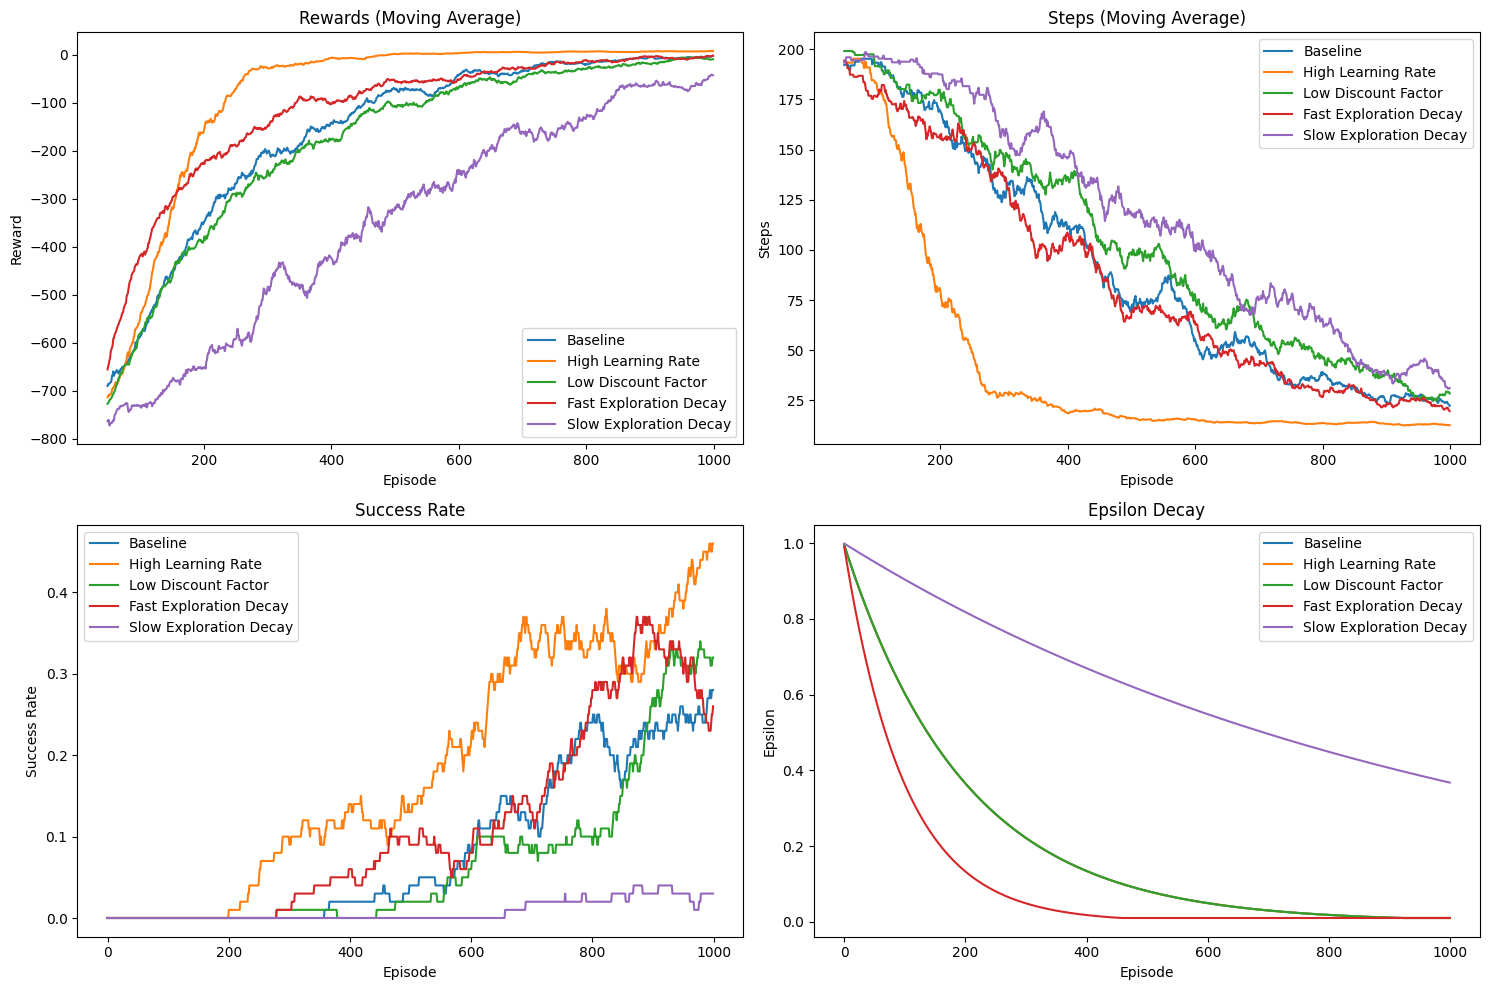


Running policy experiment: Epsilon-Greedy

Running policy experiment: Greedy

Running policy experiment: Boltzmann

Running policy experiment: UCB


In [ ]:
# experiments parameters
experiments = [
    {
        'name': 'Baseline',
        'alpha': 0.1,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.01,
        'episodes': 1000
    },
    {
        'name': 'High Learning Rate',
        'alpha': 0.5,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.01,
        'episodes': 1000
    },
    {
        'name': 'Low Discount Factor',
        'alpha': 0.1,
        'gamma': 0.8,
        'epsilon': 1.0,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.01,
        'episodes': 1000
    },
    {
        'name': 'Fast Exploration Decay',
        'alpha': 0.1,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.99,
        'epsilon_min': 0.01,
        'episodes': 1000
    },
    {
        'name': 'Slow Exploration Decay',
        'alpha': 0.1,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.999,
        'epsilon_min': 0.01,
        'episodes': 1000
    }
]

experiment_results = []

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")

# reset environment
    env = gym.make("Taxi-v3", render_mode=None)
    q_table, rewards, steps, epsilons, success_rates = q_learning(
        env,
        exp['episodes'],
        max_steps,
        exp['alpha'],
        exp['gamma'],
        exp['epsilon'],
        exp['epsilon_decay'],
        exp['epsilon_min']
    )

    avg_reward, avg_steps, success_rate = evaluate_agent(env, q_table)

    exp_result = {
        'name': exp['name'],
        'parameters': exp,
        'final_q_table': q_table,
        'rewards': rewards,
        'steps': steps,
        'epsilons': epsilons,
        'success_rates': success_rates,
        'eval_avg_reward': avg_reward,
        'eval_avg_steps': avg_steps,
        'eval_success_rate': success_rate
    }

    experiment_results.append(exp_result)

    print(f"Evaluation Results for {exp['name']}:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate:.2%}")


def compare_experiments(experiment_results):
    summary_data = {
        'Experiment': [],
        'Alpha': [],
        'Gamma': [],
        'Epsilon Decay': [],
        'Avg Reward': [],
        'Avg Steps': [],
        'Success Rate': []
    }

    for result in experiment_results:
        summary_data['Experiment'].append(result['name'])
        summary_data['Alpha'].append(result['parameters']['alpha'])
        summary_data['Gamma'].append(result['parameters']['gamma'])
        summary_data['Epsilon Decay'].append(result['parameters']['epsilon_decay'])
        summary_data['Avg Reward'].append(f"{result['eval_avg_reward']:.2f}")
        summary_data['Avg Steps'].append(f"{result['eval_avg_steps']:.2f}")
        summary_data['Success Rate'].append(f"{result['eval_success_rate']:.2%}")

    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

#learning curves
    plt.figure(figsize=(15, 10))

#rewards
    plt.subplot(2, 2, 1)
    for result in experiment_results:
        rewards_smoothed = pd.Series(result['rewards']).rolling(window=50).mean()
        plt.plot(rewards_smoothed, label=result['name'])
    plt.title('Rewards (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

#steps
    plt.subplot(2, 2, 2)
    for result in experiment_results:
        steps_smoothed = pd.Series(result['steps']).rolling(window=50).mean()
        plt.plot(steps_smoothed, label=result['name'])
    plt.title('Steps (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.legend()

#success rates
    plt.subplot(2, 2, 3)
    for result in experiment_results:
        plt.plot(result['success_rates'], label=result['name'])
    plt.title('Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.legend()

#epsilon
    plt.subplot(2, 2, 4)
    for result in experiment_results:
        plt.plot(result['epsilons'], label=result['name'])
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_experiments(experiment_results)

# test alternate policies
def greedy_policy(q_table, state, action_size):
    return np.argmax(q_table[state])

def boltzmann_policy(q_table, state, action_size, temperature=1.0):
    q_values = q_table[state]
    exp_q = np.exp(q_values / temperature)
    probabilities = exp_q / np.sum(exp_q)
    return np.random.choice(action_size, p=probabilities)

def ucb_policy(q_table, state, action_size, visit_counts, t, c=2.0):
    ucb_values = np.zeros(action_size)
    for a in range(action_size):
        if visit_counts[state, a] > 0:
            ucb_values[a] = q_table[state, a] + c * np.sqrt(np.log(t) / visit_counts[state, a])
        else:
            ucb_values[a] = float('inf')
    return np.argmax(ucb_values)

# policy experiments
policy_experiments = [
    {
        'name': 'Epsilon-Greedy',
        'policy': 'epsilon_greedy',
        'alpha': 0.1,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.01,
        'episodes': 1000
    },
    {
        'name': 'Greedy',
        'policy': 'greedy',
        'alpha': 0.1,
        'gamma': 0.99,
        'episodes': 1000
    },
    {
        'name': 'Boltzmann',
        'policy': 'boltzmann',
        'alpha': 0.1,
        'gamma': 0.99,
        'temperature': 0.5,
        'episodes': 1000
    },
    {
        'name': 'UCB',
        'policy': 'ucb',
        'alpha': 0.1,
        'gamma': 0.99,
        'c': 2.0,
        'episodes': 1000
    }
]

# q-learning with diff policies
def q_learning_with_policy(env, episodes, max_steps, alpha, gamma, policy_type, policy_params=None):

    if policy_params is None:
        policy_params = {}

    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    rewards_list = []
    steps_list = []
    success_rate = []
    successes_window = []
    window_size = 100
    visit_counts = np.zeros([env.observation_space.n, env.action_space.n])
    total_steps = 0

    for episode in tqdm(range(episodes), desc=f"Training with {policy_type} policy"):
        state, info = env.reset()
        total_reward = 0
        steps = 0
        done = False
        truncated = False

        while not done and not truncated and steps < max_steps:
            if policy_type == 'epsilon_greedy':
                epsilon = policy_params.get('epsilon', 1.0)
                if np.random.random() < epsilon:
                    action = np.random.randint(env.action_space.n)
                else:
                    action = np.argmax(q_table[state])

                # decay epsilon
                policy_params['epsilon'] = max(
                    policy_params.get('epsilon_min', 0.01),
                    policy_params.get('epsilon', 1.0) * policy_params.get('epsilon_decay', 0.995)
                )

            elif policy_type == 'greedy':
                action = greedy_policy(q_table, state, env.action_space.n)

            elif policy_type == 'boltzmann':
                action = boltzmann_policy(
                    q_table, state, env.action_space.n,
                    temperature=policy_params.get('temperature', 1.0)
                )

            elif policy_type == 'ucb':
                action = ucb_policy(
                    q_table, state, env.action_space.n,
                    visit_counts, total_steps + 1,
                    c=policy_params.get('c', 2.0)
                )

            # observing the next station
            next_state, reward, done, truncated, info = env.step(action)
            visit_counts[state, action] += 1

            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state, best_next_action]
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error
            state = next_state
            total_reward += reward
            steps += 1
            total_steps += 1

        # metrics record
        rewards_list.append(total_reward)
        steps_list.append(steps)

        if total_reward >= 9:
            successes_window.append(1)
        else:
            successes_window.append(0)

        if len(successes_window) > window_size:
            successes_window.pop(0)

        current_success_rate = sum(successes_window) / len(successes_window)
        success_rate.append(current_success_rate)

    return q_table, rewards_list, steps_list, success_rate

# policy experiments
policy_results = []

for exp in policy_experiments:
    print(f"\nRunning policy experiment: {exp['name']}")

    env = gym.make("Taxi-v3", render_mode=None)

    policy_params = {}
    if exp['policy'] == 'epsilon_greedy':
        policy_params = {
            'epsilon': exp['epsilon'],
            'epsilon_decay': exp['epsilon_decay'],
            'epsilon_min': exp['epsilon_min']
        }
    elif exp['policy'] == 'boltzmann':
        policy_params = {
            'temperature': exp['temperature']
        }
    elif exp['policy'] == 'ucb':
        policy_params = {
            'c': exp['c']
        }


In [ ]:
# policy experiments
policy_results = []

for exp in policy_experiments:
    print(f"\nRunning policy experiment: {exp['name']}")

    env = gym.make("Taxi-v3", render_mode=None)

    policy_params = {}
    if exp['policy'] == 'epsilon_greedy':
        policy_params = {
            'epsilon': exp['epsilon'],
            'epsilon_decay': exp['epsilon_decay'],
            'epsilon_min': exp['epsilon_min']
        }
    elif exp['policy'] == 'boltzmann':
        policy_params = {
            'temperature': exp['temperature']
        }
    elif exp['policy'] == 'ucb':
        policy_params = {
            'c': exp['c']
        }
    elif exp['policy'] == 'greedy':
        policy_params = {}
    q_table, rewards, steps, success_rates = q_learning_with_policy(
        env,
        exp['episodes'],
        max_steps,
        exp['alpha'],
        exp['gamma'],
        exp['policy'],
        policy_params
    )
    avg_reward, avg_steps, success_rate = evaluate_agent(env, q_table)
    exp_result = {
        'name': exp['name'],
        'parameters': exp,
        'final_q_table': q_table,
        'rewards': rewards,
        'steps': steps,
        'success_rates': success_rates,
        'eval_avg_reward': avg_reward,
        'eval_avg_steps': avg_steps,
        'eval_success_rate': success_rate
    }
    policy_results.append(exp_result)
    print(f"Evaluation Results for {exp['name']}:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate:.2%}")
def compare_policy_experiments(policy_results):
    summary_data = {
        'Experiment': [],
        'Alpha': [],
        'Gamma': [],
        'Epsilon Decay': [],
        'Avg Reward': [],
        'Avg Steps': [],
        'Success Rate': []
    }

    for result in policy_results:
        summary_data['Experiment'].append(result['name'])
        summary_data['Alpha'].append(result['parameters']['alpha'])
        summary_data['Gamma'].append(result['parameters']['gamma'])
        summary_data['Epsilon Decay'].append(result['parameters'].get('epsilon_decay', '-'))
        summary_data['Avg Reward'].append(f"{result['eval_avg_reward']:.2f}")
        summary_data['Avg Steps'].append(f"{result['eval_avg_steps']:.2f}")
        summary_data['Success Rate'].append(f"{result['eval_success_rate']:.2%}")

    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
#learning curves
    plt.figure(figsize=(15, 10))
#rewards
    plt.subplot(2, 2, 1)
    for result in policy_results:
        rewards_smoothed = pd.Series(result['rewards']).rolling(window=50).mean()
        plt.plot(rewards_smoothed, label=result['name'])
    plt.title('Rewards (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()



Running policy experiment: Epsilon-Greedy


Training with epsilon_greedy policy:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Epsilon-Greedy:
Average Reward: -57.58
Average Steps: 44.17
Success Rate: 44.00%

Running policy experiment: Greedy


Training with greedy policy:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Greedy:
Average Reward: -138.72
Average Steps: 58.92
Success Rate: 38.00%

Running policy experiment: Boltzmann


Training with boltzmann policy:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for Boltzmann:
Average Reward: -33.58
Average Steps: 46.39
Success Rate: 32.00%

Running policy experiment: UCB


Training with ucb policy:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluation Results for UCB:
Average Reward: -34.49
Average Steps: 47.09
Success Rate: 34.00%
